## <a name="C4"> Projet 5 : Segmentez les clients d'un site de e-commerce</a>
## <a name="C4"> 4 : Maintenance</a>

L'étude de la stabilité du modèle K-means dans le temps est cruciale dans le cadre d'un contrat de maintenance de modèle pour plusieurs raisons. Premièrement, les données évoluent constamment, et un modèle initialement performant peut perdre en précision si les nouvelles données diffèrent significativement de celles utilisées pour l'entraînement. Deuxièmement, la stabilité du modèle assure que les segments définis par le clustering restent cohérents et pertinents, facilitant ainsi des décisions stratégiques cohérentes. Enfin, une surveillance régulière permet de détecter et de corriger rapidement les dérives, garantissant que le modèle reste utile et efficace à long terme.

## <a name="C4"> Mise en place de l'environnement de travail</a>

In [41]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import csv
import datetime as dt
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from shapely.geometry import LineString
import warnings

print("Librairies importées avec succès !")

Librairies importées avec succès !


In [42]:
print("Version of the libraries used")
print("-----------------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)

Version of the libraries used
-----------------------------
Pandas: 2.0.3
NumPy: 1.24.3
Matplotlib: 3.7.2
Seaborn: 0.12.2


- Lecture des fichiers de données

In [43]:
orders = pd.read_csv('orders_features.csv')

print("Fichier importé avec succès !")

Fichier importé avec succès !


## <a name="C4"> Préparation </a>

In [44]:
orders['review_score'] = orders['review_score'].astype(int)
orders['payment_installments'] = orders['payment_installments'].astype(int)
orders['order_item_number'] = orders['order_item_number'].astype(int)

In [45]:
orders.rename(columns={"order_purchase_timestamp": "order_date"},
                    inplace=True)
orders["order_date"] = orders["order_date"].apply(pd.to_datetime)
orders.sort_values('order_date',
                         ascending=True,
                         inplace=True)
orders.reset_index(drop=True, inplace=True)

In [46]:
orders.head()

,customer_unique_id,order_id,payment_value,review_score,order_delivery_time_days,payment_installments,order_item_number,order_date
0,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,136.23,1,46,1,2,2016-09-04
1,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,143.46,1,55,1,3,2016-09-15
2,2f64e403852e6893ae37485d5fcacdaf,be5bc2f0da14d8071e2d45451ad119d9,39.09,4,24,1,1,2016-10-03
3,61db744d2f835035a5625b59350c6b63,a41c8759fbe7aab36ea07e038b2d4465,53.73,3,31,1,1,2016-10-03
4,10e89fd8e5c745f81bec101207ba4d7d,ef1b29b591d31d57c0d7337460dd83c9,92.27,1,29,3,1,2016-10-03


## <a name="C4"> Etude de la stabilité du modèle dans le temps </a>

- Modélisation à t0

In [47]:
def period_data(ti, orders):
    orders_i = orders.loc[orders['order_date'] < ti, :]

    date_i = orders_i["order_date"].dt\
        .date.sort_values().iloc[-1] + timedelta(days=1)
    orders_i['order_recency_days'] = orders_i[
        "order_date"].dt.date.apply(
        lambda x: date_i - x).dt.days

    X_i = orders_i.groupby('customer_unique_id').agg(
        recency=("order_recency_days", 'min'),
        frequency=("order_id", 'count'),
        monetory=("payment_value", 'sum'),
        avis=("review_score", lambda x: round(x.mean())),
        nbr_jour_livraison=("order_delivery_time_days",
                            lambda x: round(x.mean())),
        nbr_versement_moyen=("payment_installments",
                             lambda x: round(x.mean())),
        nbr_total_article=("order_item_number",
                           lambda x: round(x.sum())))
    return X_i

In [48]:
warnings.filterwarnings("ignore")
t0 = dt.datetime(2018, 3, 3)
X_0 = period_data(t0, orders)
X_0.head()

,recency,frequency,monetory,avis,nbr_jour_livraison,nbr_versement_moyen,nbr_total_article
customer_unique_id,,,,,,,
0000f46a3911fa3c0805444483337064,358,1,86.22,3,26,8,1
0000f6ccb0745a6a4b88665a16c9f078,142,1,43.62,4,20,4,1
0004aac84e0df4da2b147fca70cf8255,109,1,196.89,5,13,6,1
00053a61a98854899e70ed204dd4bafe,3,1,419.18,1,16,3,2
0005e1862207bf6ccc02e4228effd9a0,364,1,150.12,4,5,3,1


In [49]:
pca_0 = PCA(n_components=5).fit(X_0)
model_0 = Pipeline(steps=[('std', StandardScaler()),('kmeans', KMeans(init=pca_0.components_, n_clusters=5, n_init=1))])
model_0.fit(X_0)

Pipeline(steps=[('std', StandardScaler()),
                ('kmeans',
                 KMeans(init=array([[ 1.07369411e-02,  1.05176663e-04,  9.99929211e-01,
        -2.60259239e-04,  3.33195124e-03,  3.83704527e-03,
         6.21824305e-04],
       [ 9.99910969e-01, -5.18627599e-05, -1.07146778e-02,
         6.54724603e-04, -7.84482009e-03,  1.12509024e-03,
        -1.10194659e-04],
       [ 7.82166447e-03, -4.25326409e-04, -3.45038417e-03,
        -4.60821685e-02,  9.98873883e-01,  7.09487528e-03,
        -1.94884500e-03],
       [ 1.22028981e-03,  4.12312114e-04,  3.80073681e-03,
         4.66296837e-03,  7.32165419e-03, -9.99954264e-01,
         1.20063128e-04],
       [-3.05299057e-04, -1.92225459e-03,  1.35906201e-04,
         9.96339551e-01,  4.57915253e-02,  4.97210538e-03,
        -7.19868538e-02]]),
                        n_clusters=5, n_init=1))])

- Calcul du score ARI

In [50]:
warnings.filterwarnings("ignore")

ari_score_ = []
for i in range(0, 20):
    ti = t0 + i*timedelta(days=7)
    X_i = period_data(ti, orders)
    pca = PCA(n_components=5).fit(X_i)
    model = Pipeline(steps=[('std', StandardScaler()),('kmeans', KMeans(init=pca.components_,n_clusters=5,n_init=1))])
    model.fit(X_i)
    clusters = model.predict(X_i)
    clusters_0 = model_0.predict(X_i)
    ari = adjusted_rand_score(clusters_0, clusters)
    ari_score_.append([i, ari])

ari_score = pd.DataFrame(ari_score_, columns=["period", "ari_score"])
ari_score

,period,ari_score
0,0,1.000000
1,1,0.971950
2,2,0.947145
3,3,0.934556
4,4,0.920369
5,5,0.908815
6,6,0.887402
7,7,0.865911
8,8,0.854851
9,9,0.842732


- Affichage de l'évolution du score ARI

In [64]:
def ari_plot(seuil, ari_score):
    x = ari_score.period.values
    y1 = ari_score.ari_score.values
    line_1 = LineString(np.column_stack((x, y1)))
    y2 = seuil*np.ones(len(x))
    line_2 = LineString(np.column_stack((x, y2)))
    intersection = line_1.intersection(line_2)
    x_intersection, y_intersection = intersection.xy
    x_intersection = x_intersection[0]
    y_intersection = y_intersection[0]
    week_maintenance = round(x_intersection)

    print('Mise à jour du modèle :'
          + '{} semaines))'
          .format(week_maintenance))

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=ari_score,
                 x="period",
                 y="ari_score")
    plt.xlabel("Semaine")
    plt.ylabel("Score ARI")
    plt.title("Evolution de la stabilité du modèle K-Means")
              
    plt.xlim(0, 20)
    plt.ylim(0, 1)
    plt.plot(x_intersection, y_intersection)

    plt.axhline(y=seuil,
                xmin=0,
                xmax=0.57,
                color='red')
    plt.axvline(x=x_intersection,
                ymin=0,
                ymax=seuil,
                alpha=0.6,
                color='red')
    plt.grid(visible=True)
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xticks(np.arange(20))
    plt.show()
    return week_maintenance

Mise à jour du modèle :11 semaines))


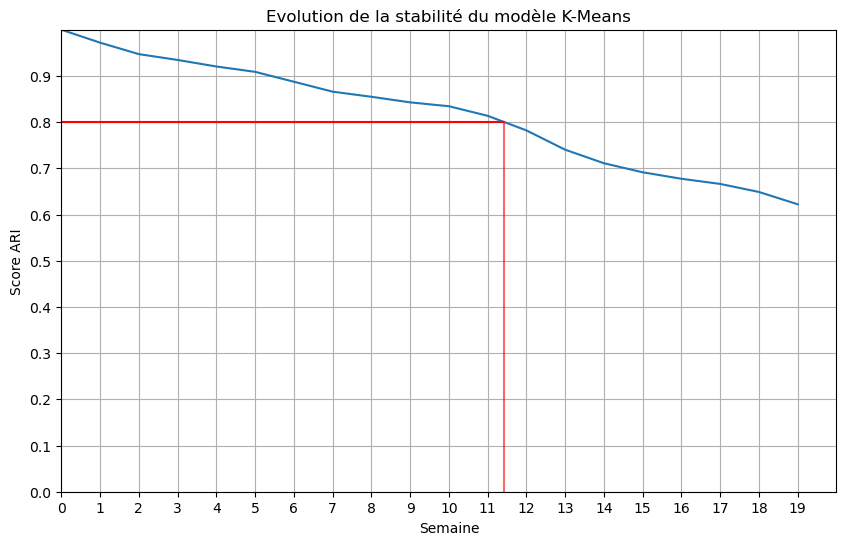

In [65]:
week_maintenance = ari_plot(seuil=0.8, ari_score=ari_score)

L'évolution de l'ARI-score (Adjusted Rand Index) au fil du temps pour un modèle K-means, mesuré sur une période de 20 semaines. Nous observons une diminution progressive de l'ARI-score, indiquant une dégradation de la stabilité du modèle K-means au fil des semaines. Notamment, à la 12ème semaine, marquée par un point rouge, l'ARI-score descend en dessous d'un seuil critique de 0.8. Cela suggère que le modèle commence à perdre significativement en performance à partir de cette période, soulignant la nécessité d'une réévaluation ou d'une mise à jour du modèle pour maintenir son efficacité.